In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules
np.set_printoptions(precision=4)

In [2]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [3]:
def featurize_mols(mol_files, max_n_atoms):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 32 == 0:
            print(idx)
        try:
            bond_dist_mat = np.zeros((max_n_atoms, max_n_atoms))
            angle_mat = np.zeros((max_n_atoms, max_n_atoms, max_n_atoms))
            angle_tuples = np.zeros((max_n_atoms, max_n_atoms, max_n_atoms)).astype(np.uint8)
            
            if ".pdb" in mol_file:
                mol = Chem.MolFromPDBFile(mol_file)
            else:
                mol = Chem.MolFromMol2File(mol_file)
            mol_xyz = get_xyz_from_mol(mol)
            centroid = compute_centroid(mol_xyz)
            mol_xyz -= centroid
            temp = np.zeros((max_n_atoms, 3))
            temp[:mol_xyz.shape[0]] = mol_xyz
            mol_xyz = temp
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            c = mol.GetConformer(0)
            
            n_bonds = 0
            n_angles = 0
            for bond in mol.GetBonds():
                n_bonds += 1
                atom_i, atom_j = (bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx())
                bond_dist_mat[atom_i, atom_j] = np.power(rdMolTransforms.GetBondLength(c, atom_i, atom_j),2)
                bond_dist_mat[atom_j, atom_i] = np.power(rdMolTransforms.GetBondLength(c, atom_i, atom_j),2)
                
                for sub_bond in bond.GetBeginAtom().GetBonds():
                    atom_k = sub_bond.GetEndAtom().GetIdx()
                    if atom_k == atom_j or atom_k==atom_i: continue
                    angle = np.cos(rdMolTransforms.GetAngleRad(c, atom_j, atom_i, atom_k))
                    angle_mat[atom_i, atom_j, atom_k] = angle
                    angle_mat[atom_i, atom_k, atom_j] = angle
                    
                    angle_tuples[atom_i, atom_j, atom_k] = 1
                    angle_tuples[atom_i, atom_k, atom_j] = 1
                    n_angles += 2
                    
                for sub_bond in bond.GetEndAtom().GetBonds():
                    atom_k = sub_bond.GetEndAtom().GetIdx()
                    if atom_k == atom_i or atom_k==atom_j: continue
                    angle = np.cos(rdMolTransforms.GetAngleRad(c, atom_i, atom_j, atom_k))
                    angle_mat[atom_j, atom_i, atom_k] = angle
                    angle_mat[atom_j, atom_k, atom_i] = angle

                    angle_tuples[atom_j, atom_i, atom_k] = 1
                    angle_tuples[atom_j, atom_k, atom_i] = 1
                    n_angles += 2
                    
            if mol is None:
                features.append(None)
                continue
                
            graph_feat = featurizer.featurize([mol])[0]
            
            features.append((mol_file, bond_dist_mat, mol_xyz, angle_mat, angle_tuples, n_bonds, n_angles, graph_feat))
        except:
            features.append(None)
    return(features)

In [4]:
import pickle
max_n_atoms = 12
S = 64
feature_file = "./voxel_features_pdbbind.pkl"
if not os.path.exists(feature_file):
#if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:] + ["/home/evan/Documents/deep_docking/alanine_dipeptide.pdb"]*S  
    features = featurize_mols(ligand_files, max_n_atoms)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

In [5]:
features = [f for f in features if f is not None]

In [6]:
len(features)

994

In [7]:
features[-1][0]

'/home/evan/Documents/deep_docking/alanine_dipeptide.pdb'

In [8]:
features[0][1].shape

(12, 12)

In [206]:
import tensorflow as tf
tf.reset_default_graph()
alpha = 0.01
n_layers = 1

S = 32

B = max_n_atoms
p = 75

z_dim = 16

L_list = [p, 64, 64, 128, 256]

dihed_per_bond = 1
valence = 4



In [207]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    #dist_matrix2d = tf.placeholder(tf.float32, shape=[S, B, B], name="dist_matrix2d")
    #bond_dist_mat = tf.placeholder(tf.float32, shape=[S, B, B], name="bond_dist_mat")
    
    #angle_tensor = tf.placeholder(tf.float32, shape=[S, B, B, B], name="angle_tensor")
    angle_tuples = tf.placeholder(tf.float32, shape=[S, B, B, B], name="angle_tuples")
    n_bonds = tf.placeholder(tf.float32, shape=[S,1], name="nbonds")
    n_angles = tf.placeholder(tf.float32, shape=[S,1], name="nangles")
    
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_normal([S, B, z_dim], mean=0, stddev=1)
    
    mol_noise = tf.random_normal([S,B,3], mean=0,stddev=0.0001)


In [208]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [209]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.

print("building clades and adj")
for i in range(n_layers):
    print(i)
    B_list.append(int(np.ceil(B_list[i]/graph_stride)))
    print(B_list)
    clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


    adj_temp = tf.matmul(clades_list[i], adj_list[i])
    sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
    sub_adj = tf.minimum(sub_adj, 1.)
    adj_list.append(sub_adj)

print("Building hidden layers")
for layer_idx in range(n_layers):
    GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
    Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
    DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
    Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

f_w1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]))
f_b1 = tf.Variable(tf.ones([L_list[n_layers]]))

g_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]*2+z_dim, 64]))
g_w1 = tf.tile(g_w1_ini, [S, 1, 1])

g_b1 = tf.Variable(tf.ones([1, 1, 64]))

g_w2_ini = tf.Variable(tf.truncated_normal([1, 64, 3]))
g_w2 = tf.tile(g_w2_ini, [S, 1, 1])
g_b2 = tf.Variable(tf.ones([1, 1, 3]))

d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
d_b1 = tf.Variable(tf.ones([1, 1, 32]))

d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
d_b2 = tf.Variable(tf.ones([1, 1, 1]))

lam1 = tf.Variable(tf.constant(0.01))
lam2 = tf.Variable(tf.constant(0.01))

building clades and adj
0
[12, 12]
Building hidden layers


In [210]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [211]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [212]:
def compute_angle_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)

def compute_dist_tensor(mols_batch):
    dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols_batch, S, axis=0)], axis=0)
    #dist_matrix = tf.where(tf.is_nan(dist_matrix), tf.ones_like(dist_matrix) * 0., dist_matrix)
    print("dist_matrix")
    print(dist_matrix)
    #dist_matrix = compute_distance_matrix(mol)
    return(dist_matrix)

"""
def compute_dihedral_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    cross = tf.cross(ij, ik)
    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))
    
    ijk = tf.tile(tf.reshape(cross, [S, B, B, 1, B, 3]), [1m 1])
    
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)
"""

'\ndef compute_dihedral_tensor(mols_batch, angle_tuples_batch):\n    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])\n    i_vec = tf.tile(i_vec, [1, 1, B, 1])\n\n    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])\n    j_vec = tf.tile(j_vec, [1, B, 1, 1])\n\n    diff = tf.subtract(i_vec, j_vec)\n    temp = tf.eye(B, batch_shape=[S])\n    temp = tf.reshape(temp, [S, B, B, 1])\n    temp = tf.tile(temp, [1, 1, 1, 3])\n    diff = diff + temp\n    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))\n    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))\n    diff = tf.subtract(diff, temp)\n\n    print("diff should be [S, B, B, 3]")\n    print(diff)\n\n    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])\n    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])\n    cross = tf.cross(ij, ik)\n    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))\n    \n    ijk = tf.tile(tf.reshape(cross, [S, B, 

In [213]:
def generator(W_list, b_list, h_list, L_list, n_layers):
    for layer_idx in range(n_layers):
        h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                     b_list[layer_idx], adj_list[layer_idx], 
                                                     clades_list[layer_idx],
                                                     L_list[layer_idx], L_list[layer_idx+1],
                                                     layer_idx, S, B_list[layer_idx]), keep_prob))
    L_final = L_list[n_layers]  
    
    print("h_list[-1]")
    print(h_list[-1])
    
    print("B_list")
    print(B_list)
    
    fingerprints = tf.tile(tf.reshape(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_w1) + f_b1), [S, 1, L_final]), [1, B, 1])
    h_final = tf.concat([h_list[-1], fingerprints, z], axis=2)

    
    print("h afterz")
    print(h_final)
    
    g_h1 = tf.nn.dropout(leaky_relu(tf.matmul(h_final, g_w1) + g_b1), keep_prob)
    #g_h1 = tf.reshape(g_h1, [S, 5, 16])
    print("g_h1")
    print(g_h1)
    g_h2 = tf.reshape(tf.matmul(g_h1, g_w2) + g_b2, [S, B, 3])
    #g_h2 = tf.clip_by_value(g_h2, -10., 10.)
    return(g_h2)



In [214]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols, mol_xyz):
    mols = tf.add(mols, mol_noise)
    print("mols")
    print(mols)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]

        #COMPUTE ANGLE LOSS:
        angle_tensor = compute_angle_tensor(mol_xyz, angle_tuples)
        angles_gen = compute_angle_tensor(mols, angle_tuples)

        
        wrong_angle_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.squared_difference(angles_gen, angle_tensor), axis=[1,2,3]), lam2), (S,1)), n_angles)
        #wrong_angle_loss = tf.where(tf.is_nan(wrong_angle_loss), tf.zeros_like(wrong_angle_loss), wrong_angle_loss)

        #wrong_angle_loss = tf.minimum(wrong_angle_loss, 3.14**2)
        print("wrong_angle_loss")
        print(wrong_angle_loss)
        
        #COMPUTE BOND LOSS:
        dist_matrix_gen = compute_dist_tensor(mols)
        bond_dist_gen = tf.multiply(dist_matrix_gen, adj_matrix)
        
        dist_matrix_real = compute_dist_tensor(mol_xyz)
        bond_dist_real = tf.multiply(dist_matrix_real, adj_matrix)

 
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_real, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)
        
        #COMPUTE DIHEDRAL LOSS?
        
        
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix_gen, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = tf.nn.dropout(leaky_relu(tf.matmul(d_h1, d_w1) + d_b1), keep_prob)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(tf.add(tf.add(wrong_bond_loss, tf.multiply(wrong_angle_loss, 1.)), d_h2), bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angle_loss)

In [215]:

theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2] + [lam1, lam2]

theta_G =  GW_list[:n_layers] + Gb_list[:n_layers] + [g_w1_ini, g_b1, g_w2_ini, g_b2, f_w1, f_b1]

In [216]:
import time 

with tf.device('/gpu:0'):    

    G_sample = generator(GW_list, Gb_list, Gh_list, L_list, n_layers)

    D_real, bond_dist_real, angles_gen_real, wrong_bond_real, wrong_angle_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, mol_xyz)
    D_fake, bond_dist_fake, angles_gen_fake, wrong_bond_fake, wrong_angle_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, G_sample, mol_xyz)


    D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    G_loss = -tf.reduce_mean(D_fake)
    clip_D = []
    for p in theta_D[:-2]:
        #print(p)
        clip_D.append(p.assign(tf.clip_by_value(p, -0.01, 0.01)))
    clip_D.append(lam1.assign(tf.clip_by_value(lam1, 0.001, 0.002)))
    clip_D.append(lam2.assign(tf.clip_by_value(lam2, 0.001, 0.002)))

    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))


    

layer_idx: 0
within func h:
Tensor("MatMul_2:0", shape=(32, 12, 64), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("dropout/mul:0", shape=(32, 12, 64), dtype=float32, device=/device:GPU:0)
B_list
[12, 12]
h afterz
Tensor("concat:0", shape=(32, 12, 144), dtype=float32, device=/device:GPU:0)
g_h1
Tensor("dropout_1/mul:0", shape=(32, 12, 64), dtype=float32, device=/device:GPU:0)
mols
Tensor("Add:0", shape=(32, 12, 3), dtype=float32, device=/device:GPU:0)
layer_idx: 0
within func h:
Tensor("MatMul_6:0", shape=(32, 12, 64), dtype=float32, device=/device:GPU:0)
diff should be [S, B, B, 3]
Tensor("Sub_1:0", shape=(32, 12, 12, 3), dtype=float32, device=/device:GPU:0)
dps should be [S, B, B, B]
Tensor("Sum_3:0", shape=(32, 12, 12, 12), dtype=float32, device=/device:GPU:0)
diff should be [S, B, B, 3]
Tensor("Sub_3:0", shape=(32, 12, 12, 3), dtype=float32, device=/device:GPU:0)
dps should be [S, B, B, B]
Tensor("Sum_6:0", shape=(32, 12, 12, 12), dtype=float32, device=/device:GPU:0)
wrong

In [217]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob_val=1.0, train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][7][0] for idx in inds]
    A_batch = np.array([X[idx][7][1] for idx in inds])
    mol_xyz_batch = [X[idx][2] for idx in inds]
    mol_xyz_batch = rotate_molecules(mol_xyz_batch)

    angle_tuples_batch = [X[idx][4] for idx in inds]
    n_bonds_batch = np.reshape(np.array([X[idx][5] for idx in inds]), [S,1])
    n_angles_batch = np.reshape(np.array([X[idx][6] for idx in inds]), [S,1])

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 mol_xyz: mol_xyz_batch,
                 angle_tuples: angle_tuples_batch,
                 n_bonds: n_bonds_batch,
                 n_angles: n_angles_batch,
                 keep_prob: keep_prob_val
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [218]:
def generate_molecule(mol_file, new_coords, new_file):
    print(mol_file)
    print(new_coords[:4])
    if ".pdb" in mol_file:
        mol = Chem.MolFromPDBFile(mol_file)
    else:
        mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

In [ ]:
features[3][0]

'/home/evan/Documents/deep_docking/datasets/v2015/3s77/3s77_ligand.mol2'

In [ ]:
every = 100
train_dataset = features[:64*12]
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:

        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features, 0, S, shuffle_inds=False, keep_prob_val=1.)

        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        
        
        print("bond real:")
        print(sess.run(bond_dist_real, feed_dict=feed_dict)[0][:4,:4])
        #print(sess.run(computed_dist_real, feed_dict=feed_dict)[0][:4])

        #print(feed_dict[bond_dist_mat][0][:4])


        print("bond fake:")
        print(sess.run(bond_dist_fake, feed_dict=feed_dict)[0][:4,:4])
    
        #print("angles real:")
        #print(feed_dict[angle_tensor][0][2,:4,:4])
        print("angles real computed")
        
        print(sess.run(angles_gen_real, feed_dict=feed_dict)[0][2,:4,:4])
        print("angles fake:")
        print(sess.run(angles_gen_fake, feed_dict=feed_dict)[0][2,:4,:4])
        
        print("bond loss real:")
        print(sess.run(wrong_bond_real, feed_dict=feed_dict)[:4])
        print("bond loss fake:")
        print(sess.run(wrong_bond_fake, feed_dict=feed_dict))[:4] 

        print("angle loss real:")
        print(sess.run(wrong_angle_real, feed_dict=feed_dict)[:4])
        print("angle loss fake:")
        print(sess.run(wrong_angle_fake, feed_dict=feed_dict)[:4])

        print("lam1")
        print(sess.run(lam1, feed_dict=feed_dict))
        print("lam2")
        print(sess.run(lam2, feed_dict=feed_dict))
        
        print("\n\n\n")
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



2.00235199928
Training epoch 0
Iter: 0
D loss: -3e+03
G_loss: 8.681e+03
real:
[[-0.5771 -0.132   1.6194]
 [-0.2458  0.8916  0.512 ]
 [ 0.5299  0.2861 -0.839 ]
 [ 0.293  -1.0458 -1.2925]]
fake:
[[ 54.3732  37.5077   8.5255]
 [ 53.7052   9.8994  14.2594]
 [ 62.7978   8.2975  12.4038]
 [ 56.8955  18.0756   7.5751]]
bond real:
[[ 0.      2.384   0.      0.    ]
 [ 2.384   0.      2.7934  0.    ]
 [ 0.      2.7934  0.      2.0357]
 [ 0.      0.      2.0357  0.    ]]
bond fake:
[[   0.      315.2351    0.        0.    ]
 [ 315.2351    0.      209.2322    0.    ]
 [   0.      209.2322    0.      341.5046]
 [   0.        0.      341.5046    0.    ]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5181]
 [ 0.      0.      0.     -0.    ]
 [-0.     -0.5181 -0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.     -0.      0.7323]
 [ 0.     -0.      0.     -0.    ]
 [ 0.      0.7323 -0.      0.    ]]
bond loss real:
[[ -1.5137e-10]
 [

1.36917090416
Training epoch 500
Iter: 500
D loss: 0.07105
G_loss: 0.849
real:
[[ 0.1262 -1.6379 -0.524 ]
 [ 0.0842 -0.1825 -1.0379]
 [-0.2918  0.986   0.0966]
 [ 0.0814  0.8344  1.4653]]
fake:
[[ -2.1854  11.8097  -3.6363]
 [ -3.5068  10.717   -4.2168]
 [ -3.5828   9.1241  -3.3544]
 [ -3.6084   9.4975  -2.0282]]
bond real:
[[ 0.      2.3846  0.      0.    ]
 [ 2.3846  0.      2.7937  0.    ]
 [ 0.      2.7937  0.      2.036 ]
 [ 0.      0.      2.036   0.    ]]
bond fake:
[[  0.0000e+00   3.4940e+00   0.0000e+00   0.0000e+00]
 [  3.4940e+00   0.0000e+00   3.3015e+00   0.0000e+00]
 [  0.0000e+00   3.3015e+00   0.0000e+00   1.8029e+00]
 [  0.0000e+00   0.0000e+00   1.8029e+00  -1.5259e-05]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5181]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5181  0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.1357]
 [ 0.      0.      0.      0.    ]
 [ 0.     -0.1357  0.

1.37191700935
Training epoch 1000
Iter: 1000
D loss: 0.02522
G_loss: 0.4041
real:
[[-0.2403  0.4941  1.6344]
 [ 0.8497  0.2837  0.5613]
 [ 0.3579 -0.4712 -0.8465]
 [-0.9672 -0.3066 -1.3492]]
fake:
[[ 6.7737  9.8144 -7.8952]
 [ 5.6809  8.5912 -8.5241]
 [ 5.1748  8.0683 -7.145 ]
 [ 6.0128  8.2567 -6.3257]]
bond real:
[[  0.0000e+00   2.3838e+00   0.0000e+00   0.0000e+00]
 [  2.3838e+00   2.3842e-07   2.7936e+00   0.0000e+00]
 [  0.0000e+00   2.7936e+00   0.0000e+00   2.0356e+00]
 [  0.0000e+00   0.0000e+00   2.0356e+00   0.0000e+00]]
bond fake:
[[ 0.      2.9863  0.      0.    ]
 [ 2.9863  0.      1.9986  0.    ]
 [ 0.      1.9986  0.      1.2919]
 [ 0.      0.      1.2919  0.    ]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5179]
 [ 0.      0.      0.     -0.    ]
 [-0.     -0.5179 -0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.     -0.     -0.1736]
 [ 0.     -0.      0.      0.    ]
 [ 0.     -0.1736  0.      0. 

1.37011814117
Training epoch 1500
Iter: 1500
D loss: 0.05121
G_loss: 0.6338
real:
[[-1.1052 -0.4602 -1.2409]
 [-0.7254  0.7065 -0.3036]
 [ 0.4013  0.3594  0.8811]
 [ 1.4294 -0.6057  0.6633]]
fake:
[[ 13.3878   7.4115  -6.3974]
 [ 12.9029   6.0922  -6.697 ]
 [ 11.8516   5.0724  -6.1927]
 [ 11.6953   5.5798  -5.0762]]
bond real:
[[ 0.      2.3846  0.      0.    ]
 [ 2.3846  0.      2.7925  0.    ]
 [ 0.      2.7925  0.      2.036 ]
 [ 0.      0.      2.036   0.    ]]
bond fake:
[[ 0.      2.0562  0.      0.    ]
 [ 2.0562  0.      2.4856  0.    ]
 [ 0.      2.4856  0.      1.2919]
 [ 0.      0.      1.2919  0.    ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5178]
 [-0.     -0.      0.     -0.    ]
 [-0.     -0.5178 -0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.0279]
 [ 0.      0.      0.      0.    ]
 [ 0.     -0.0279  0.      0.    ]]
bond loss real:
[[ -2.1201e-10]
 [ -1.0043e-09]
 [ -1.0530e-09

1.36793494225
Training epoch 2000
Iter: 2000
D loss: 0.009867
G_loss: 0.01974
real:
[[-0.9969  1.3968  0.1677]
 [-0.9149 -0.1044  0.5192]
 [ 0.332  -0.9584 -0.1946]
 [ 1.5798 -0.3341 -0.4923]]
fake:
[[ 13.5474   8.0637  -7.6544]
 [ 12.8556   6.8405  -7.778 ]
 [ 12.7614   5.4919  -7.1506]
 [ 11.6771   5.8922  -6.3039]]
bond real:
[[  0.0000e+00   2.3843e+00   0.0000e+00   0.0000e+00]
 [  2.3843e+00   0.0000e+00   2.7941e+00   0.0000e+00]
 [  0.0000e+00   2.7941e+00   2.3842e-07   2.0354e+00]
 [  0.0000e+00   0.0000e+00   2.0354e+00  -4.7684e-07]]
bond fake:
[[  0.0000e+00   2.1304e+00   0.0000e+00   0.0000e+00]
 [  2.1304e+00   0.0000e+00   2.4038e+00   0.0000e+00]
 [  0.0000e+00   2.4038e+00   0.0000e+00   2.2913e+00]
 [  0.0000e+00   0.0000e+00   2.2913e+00  -3.0518e-05]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5178]
 [ 0.      0.      0.      0.    ]
 [-0.     -0.5178  0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0. 

1.36704421043
Training epoch 2500
Iter: 2500
D loss: 0.04619
G_loss: 0.5741
real:
[[-0.1014 -0.4493  1.6616]
 [ 0.8833  0.0433  0.5792]
 [ 0.2979  0.075  -0.986 ]
 [-1.0798  0.3309 -1.2547]]
fake:
[[ 13.651    8.2209  -2.404 ]
 [ 13.4391   6.7137  -2.4063]
 [ 13.069    5.5952  -1.784 ]
 [ 11.5975   6.0255  -2.039 ]]
bond real:
[[ 0.      2.3836  0.      0.    ]
 [ 2.3836  0.      2.7933  0.    ]
 [ 0.      2.7933  0.      2.0359]
 [ 0.      0.      2.0359  0.    ]]
bond fake:
[[ 0.      2.1432  0.      0.    ]
 [ 2.1432  0.      1.6511  0.    ]
 [ 0.      1.6511  0.      2.118 ]
 [ 0.      0.      2.118   0.    ]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5178]
 [ 0.      0.      0.     -0.    ]
 [-0.     -0.5178 -0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.0197]
 [ 0.      0.      0.     -0.    ]
 [ 0.      0.0197 -0.      0.    ]]
bond loss real:
[[ -2.4207e-09]
 [ -2.0309e-09]
 [ -1.2002e-09

1.37497496605
Training epoch 3000
Iter: 3000
D loss: 0.05691
G_loss: -0.8324
real:
[[-1.3827 -0.4569  0.9233]
 [-0.2623  0.6013  0.829 ]
 [ 0.9538  0.2865 -0.2736]
 [ 0.6913 -0.4309 -1.4786]]
fake:
[[ 11.5019   9.8631  -4.1333]
 [ 11.7593   8.1766  -3.9499]
 [ 11.439    7.1324  -2.9204]
 [ 10.0652   7.1529  -3.0961]]
bond real:
[[ 0.      2.3845  0.      0.    ]
 [ 2.3845  0.      2.7931  0.    ]
 [ 0.      2.7931  0.      2.0355]
 [ 0.      0.      2.0355  0.    ]]
bond fake:
[[ 0.      2.933   0.      0.    ]
 [ 2.933   0.      2.1051  0.    ]
 [ 0.      2.1051  0.      1.8713]
 [ 0.      0.      1.8713  0.    ]]
angles real computed
[[ 0.     0.    -0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [-0.     0.     0.    -0.   ]
 [-0.    -0.518 -0.     0.   ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.0911]
 [ 0.      0.      0.     -0.    ]
 [ 0.     -0.0911 -0.      0.    ]]
bond loss real:
[[ -2.9096e-09]
 [ -2.5326e-09]
 [ -2.0604e-09]
 [ -2.3356e-0

1.36725401878
Training epoch 3500
Iter: 3500
D loss: 0.02512
G_loss: 0.2325
real:
[[ 0.5821  1.5165  0.5784]
 [-0.6228  0.8462 -0.1165]
 [-0.4044 -0.7399 -0.5964]
 [ 0.4451 -1.6228  0.1345]]
fake:
[[ 11.7444  15.0835  -2.0909]
 [ 12.0505  13.8464  -1.7606]
 [ 11.6705  12.1756  -1.3099]
 [ 10.4388  12.2096  -1.8508]]
bond real:
[[  0.0000e+00   2.3846e+00   0.0000e+00   0.0000e+00]
 [  2.3846e+00   2.3842e-07   2.7947e+00   0.0000e+00]
 [  0.0000e+00   2.7947e+00   0.0000e+00   2.0359e+00]
 [  0.0000e+00   0.0000e+00   2.0359e+00   0.0000e+00]]
bond fake:
[[ 0.      1.4588  0.      0.    ]
 [ 1.4588  0.      3.3561  0.    ]
 [ 0.      3.3561  0.      2.1396]
 [ 0.      0.      2.1396  0.    ]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5179]
 [ 0.      0.      0.      0.    ]
 [-0.     -0.5179  0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.1172]
 [ 0.      0.      0.     -0.    ]
 [ 0.     -0.1172 

1.36800503731
Training epoch 4000
Iter: 4000
D loss: 0.004915
G_loss: -0.1871
real:
[[ 0.9079 -1.3403 -0.5935]
 [-0.4127 -0.5655 -0.7921]
 [-0.7657  0.5913  0.3615]
 [ 0.2705  1.3145  1.0241]]
fake:
[[ 10.4002  15.2841  -2.6363]
 [ 10.2131  13.9324  -2.2657]
 [  9.5091  12.5678  -1.4177]
 [  8.4109  12.606   -1.9872]]
bond real:
[[  0.0000e+00   2.3840e+00   0.0000e+00   0.0000e+00]
 [  2.3840e+00   0.0000e+00   2.7940e+00   0.0000e+00]
 [  0.0000e+00   2.7940e+00   0.0000e+00   2.0357e+00]
 [  0.0000e+00   0.0000e+00   2.0357e+00   4.7684e-07]]
bond fake:
[[  6.1035e-05   1.9617e+00   0.0000e+00   0.0000e+00]
 [  1.9617e+00   0.0000e+00   3.1342e+00   0.0000e+00]
 [  0.0000e+00   3.1342e+00   0.0000e+00   1.3783e+00]
 [  0.0000e+00   0.0000e+00   1.3783e+00  -3.0518e-05]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5182]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5182  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0. 

1.36492705345
Training epoch 4500
Iter: 4500
D loss: 0.03576
G_loss: 0.4093
real:
[[ 0.5519 -1.6187  0.2198]
 [-0.5358 -0.6191  0.6687]
 [-0.3268  0.964   0.1749]
 [ 0.3107  1.2738 -1.0634]]
fake:
[[  9.1062  17.1936  -6.7963]
 [  9.3652  15.7982  -6.7541]
 [  9.2447  13.991   -6.1965]
 [  7.9895  14.0149  -6.8752]]
bond real:
[[  0.0000e+00   2.3834e+00   0.0000e+00   0.0000e+00]
 [  2.3834e+00   0.0000e+00   2.7937e+00   0.0000e+00]
 [  0.0000e+00   2.7937e+00   0.0000e+00   2.0358e+00]
 [  0.0000e+00   0.0000e+00   2.0358e+00   4.7684e-07]]
bond fake:
[[ 0.      2.2014  0.      0.    ]
 [ 2.2014  0.      3.2812  0.    ]
 [ 0.      3.2812  0.      2.0039]
 [ 0.      0.      2.0039  0.    ]]
angles real computed
[[ 0.     0.    -0.    -0.   ]
 [ 0.     0.    -0.    -0.518]
 [-0.    -0.     0.    -0.   ]
 [-0.    -0.518 -0.     0.   ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.0744]
 [ 0.      0.      0.     -0.    ]
 [ 0.      0.0744 -0.      0.    ]

1.36376881599
Training epoch 5000
Iter: 5000
D loss: 0.02439
G_loss: 0.1289
real:
[[-0.0082 -1.1544 -1.2808]
 [-0.8952 -0.5325 -0.1806]
 [-0.1156  0.4546  0.9201]
 [ 1.019   1.2323  0.5413]]
fake:
[[ 10.2537  13.371   -5.8706]
 [ 10.0604  11.8209  -5.8483]
 [  9.3803  10.4314  -5.507 ]
 [  8.7242   9.8089  -6.3036]]
bond real:
[[ -4.7684e-07   2.3842e+00   0.0000e+00   0.0000e+00]
 [  2.3842e+00   0.0000e+00   2.7930e+00   0.0000e+00]
 [  0.0000e+00   2.7930e+00   0.0000e+00   2.0356e+00]
 [  0.0000e+00   0.0000e+00   2.0356e+00  -4.7684e-07]]
bond fake:
[[  6.1035e-05   2.4715e+00   0.0000e+00   0.0000e+00]
 [  2.4715e+00   0.0000e+00   1.9289e+00   0.0000e+00]
 [  0.0000e+00   1.9289e+00   0.0000e+00   1.7737e+00]
 [  0.0000e+00   0.0000e+00   1.7737e+00   0.0000e+00]]
angles real computed
[[ 0.     0.    -0.    -0.   ]
 [ 0.     0.    -0.    -0.518]
 [-0.    -0.     0.     0.   ]
 [-0.    -0.518  0.     0.   ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.   

1.37182402611
Training epoch 5500
Iter: 5500
D loss: 0.04121
G_loss: 0.4152
real:
[[-0.0485 -0.7823  1.5358]
 [ 0.2036  0.5822  0.8586]
 [ 0.2978  0.5672 -0.8101]
 [-0.4529 -0.3671 -1.5843]]
fake:
[[  9.6323  11.9191  -6.8725]
 [  9.6379  10.4706  -6.3658]
 [  8.9815   9.8506  -5.2809]
 [  8.3395   8.8456  -5.7014]]
bond real:
[[  0.0000e+00   2.3836e+00   0.0000e+00   0.0000e+00]
 [  2.3836e+00   2.3842e-07   2.7940e+00   0.0000e+00]
 [  0.0000e+00   2.7940e+00   2.3842e-07   2.0359e+00]
 [  0.0000e+00   0.0000e+00   2.0359e+00   0.0000e+00]]
bond fake:
[[  0.0000e+00   2.4144e+00   0.0000e+00   0.0000e+00]
 [  2.4144e+00   0.0000e+00   1.8813e+00   0.0000e+00]
 [  0.0000e+00   1.8813e+00   0.0000e+00   1.9551e+00]
 [  0.0000e+00   0.0000e+00   1.9551e+00   3.0518e-05]]
angles real computed
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.    -0.   ]
 [-0.    -0.518 -0.     0.   ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.     -0.   

1.37312602997
Training epoch 6000
Iter: 6000
D loss: 0.02264
G_loss: 0.09674
real:
[[-0.8381  0.9195 -1.1939]
 [ 0.2265 -0.1846 -1.016 ]
 [ 0.7436 -0.4604  0.5494]
 [-0.132  -0.2745  1.6605]]
fake:
[[  7.2653  16.5786  -7.4215]
 [  7.4705  15.2171  -7.0248]
 [  6.5839  13.978   -5.9751]
 [  7.1341  12.7571  -6.4671]]
bond real:
[[ 0.      2.3834  0.      0.    ]
 [ 2.3834  0.      2.7936  0.    ]
 [ 0.      2.7936  0.      2.0358]
 [ 0.      0.      2.0358  0.    ]]
bond fake:
[[ 0.      1.8655  0.      0.    ]
 [ 1.8655  0.      3.7254  0.    ]
 [ 0.      3.7254  0.      2.0582]
 [ 0.      0.      2.0582  0.    ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5179]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5179  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.1854]
 [ 0.      0.      0.     -0.    ]
 [-0.     -0.1854 -0.      0.    ]]
bond loss real:
[[ -7.7925e-10]
 [ -8.2701e-10]
 [ -1.4006e-0

1.3589220047
Training epoch 6500
Iter: 6500
D loss: 0.02328
G_loss: 0.1175
real:
[[-0.4077 -0.9368  1.389 ]
 [ 0.0893  0.4572  0.949 ]
 [ 0.4951  0.6162 -0.6646]
 [-0.1767 -0.1367 -1.6733]]
fake:
[[  8.0269  14.4189  -7.7702]
 [  8.7094  13.0491  -7.2226]
 [  7.7398  12.2597  -6.5331]
 [  7.9147  11.1295  -6.8187]]
bond real:
[[ 0.      2.3839  0.      0.    ]
 [ 2.3839  0.      2.7927  0.    ]
 [ 0.      2.7927  0.      2.0357]
 [ 0.      0.      2.0357  0.    ]]
bond fake:
[[ 0.      2.5949  0.      0.    ]
 [ 2.5949  0.      2.0161  0.    ]
 [ 0.      2.0161  0.      1.8804]
 [ 0.      0.      1.8804  0.    ]]
angles real computed
[[ 0.     0.    -0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [-0.     0.     0.    -0.   ]
 [-0.    -0.518 -0.     0.   ]]
angles fake:
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.389]
 [ 0.     0.     0.    -0.   ]
 [-0.    -0.389 -0.     0.   ]]
bond loss real:
[[ -2.4843e-09]
 [ -2.2437e-09]
 [ -1.4595e-09]
 [ -2.3675e-09]]
bond loss fake

1.3542881012
Training epoch 7000
Iter: 7000
D loss: 0.02053
G_loss: -0.04191
real:
[[ 0.4087 -0.4538  1.6125]
 [ 0.1022  0.7678  0.7194]
 [-0.0132  0.4676 -0.9208]
 [-0.4976 -0.7816 -1.4111]]
fake:
[[  8.7171  16.0369  -6.7651]
 [  9.1191  14.4928  -6.5453]
 [  8.3257  13.2844  -5.8934]
 [  8.4361  12.2415  -6.2165]]
bond real:
[[ 0.      2.3835  0.      0.    ]
 [ 2.3835  0.      2.7941  0.    ]
 [ 0.      2.7941  0.      2.0361]
 [ 0.      0.      2.0361  0.    ]]
bond fake:
[[  0.0000e+00   2.7920e+00   0.0000e+00   0.0000e+00]
 [  2.7920e+00   1.2207e-04   2.4932e+00   0.0000e+00]
 [  0.0000e+00   2.4932e+00   0.0000e+00   1.4649e+00]
 [  0.0000e+00   0.0000e+00   1.4649e+00   0.0000e+00]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5178]
 [ 0.      0.      0.     -0.    ]
 [-0.     -0.5178 -0.      0.    ]]
angles fake:
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.585]
 [ 0.     0.     0.    -0.   ]
 [-0.    -0.585 -0.     0.   

1.35047698021
Training epoch 7500
Iter: 7500
D loss: 0.01071
G_loss: -0.08374
real:
[[-0.3722 -1.2328 -1.1466]
 [-0.7676  0.1917 -0.7012]
 [-0.0814  0.7322  0.7238]
 [ 1.2211  0.309   1.124 ]]
fake:
[[  5.8587  17.5162 -10.3393]
 [  6.6334  16.3211 -10.0947]
 [  7.1668  15.2298  -8.9315]
 [  6.8919  13.7827  -9.0332]]
bond real:
[[  0.0000e+00   2.3844e+00   0.0000e+00   0.0000e+00]
 [  2.3844e+00   0.0000e+00   2.7933e+00   0.0000e+00]
 [  0.0000e+00   2.7933e+00   2.3842e-07   2.0354e+00]
 [  0.0000e+00   0.0000e+00   2.0354e+00   0.0000e+00]]
bond fake:
[[ 0.      2.0969  0.      0.    ]
 [ 2.0969  0.      2.7882  0.    ]
 [ 0.      2.7882  0.      2.1489]
 [ 0.      0.      2.1489  0.    ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5179]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5179  0.      0.    ]]
angles fake:
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5237]
 [-0.     -0.      0.     -0.    ]
 [-0.     -0.523

1.37346506119
Training epoch 8000
Iter: 8000
D loss: 0.01447
G_loss: -1.459
real:
[[-0.5733  0.5011  1.547 ]
 [-1.0455  0.0565  0.1459]
 [ 0.1447 -0.0858 -1.019 ]
 [ 1.4742 -0.4718 -0.6739]]
fake:
[[  4.4084  22.149   -8.6109]
 [  4.8273  20.691   -8.8084]
 [  5.9607  19.4443  -7.8593]
 [  4.9402  18.1034  -7.7015]]
bond real:
[[ 0.      2.3832  0.      0.    ]
 [ 2.3832  0.      2.7937  0.    ]
 [ 0.      2.7937  0.      2.0359]
 [ 0.      0.      2.0359  0.    ]]
bond fake:
[[  0.0000e+00   2.2431e+00   0.0000e+00   0.0000e+00]
 [  2.2431e+00   0.0000e+00   3.8059e+00   0.0000e+00]
 [  0.0000e+00   3.8059e+00   6.1035e-05   2.8238e+00]
 [  0.0000e+00   0.0000e+00   2.8238e+00   6.1035e-05]]
angles real computed
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [-0.    -0.518  0.     0.   ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.     -0.     -0.2917]
 [ 0.     -0.      0.     -0.    ]
 [-0.     -0.2917 -0.      0.    ]

1.36173987389
Training epoch 8500
Iter: 8500
D loss: 0.06477
G_loss: -0.1643
real:
[[ 0.9365 -0.8449  1.1757]
 [ 0.8999  0.4461  0.3297]
 [-0.2882  0.5216 -0.8435]
 [-1.5481 -0.1229 -0.6619]]
fake:
[[  5.7715  23.7393  -8.8107]
 [  7.0362  22.9012  -8.5315]
 [  7.8495  21.5421  -7.5842]
 [  6.9032  20.581   -7.1204]]
bond real:
[[  4.7684e-07   2.3837e+00   0.0000e+00   0.0000e+00]
 [  2.3837e+00   0.0000e+00   2.7935e+00   0.0000e+00]
 [  0.0000e+00   2.7935e+00  -2.3842e-07   2.0361e+00]
 [  0.0000e+00   0.0000e+00   2.0361e+00   0.0000e+00]]
bond fake:
[[ 0.      2.2227  0.      0.    ]
 [ 2.2227  0.      3.3115  0.    ]
 [ 0.      3.3115  0.      2.283 ]
 [ 0.      0.      2.283   0.    ]]
angles real computed
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.    -0.   ]
 [-0.    -0.518 -0.     0.   ]]
angles fake:
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.4191]
 [-0.     -0.      0.     -0.    ]
 [-0.     -0.4191 -0.      0.    

1.36856794357
Training epoch 9000
Iter: 9000
D loss: 0.02016
G_loss: -0.502
real:
[[ 1.2532 -1.0072  0.6231]
 [ 0.9347  0.4464  0.2112]
 [-0.5261  0.6862 -0.5648]
 [-1.6618 -0.1254 -0.2696]]
fake:
[[  3.4233  23.061   -7.116 ]
 [  4.641   22.1258  -7.481 ]
 [  5.552   20.8703  -7.1528]
 [  4.6099  20.1776  -6.3827]]
bond real:
[[  0.0000e+00   2.3839e+00   0.0000e+00   0.0000e+00]
 [  2.3839e+00   0.0000e+00   2.7936e+00   0.0000e+00]
 [  0.0000e+00   2.7936e+00   2.3842e-07   2.0357e+00]
 [  0.0000e+00   0.0000e+00   2.0357e+00   0.0000e+00]]
bond fake:
[[  0.0000e+00   2.4737e+00   0.0000e+00   0.0000e+00]
 [  2.4737e+00   0.0000e+00   2.5522e+00   0.0000e+00]
 [  0.0000e+00   2.5522e+00   0.0000e+00   2.0781e+00]
 [  0.0000e+00   0.0000e+00   2.0781e+00   6.1035e-05]]
angles real computed
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.    -0.   ]
 [-0.    -0.518 -0.     0.   ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.     -0.   

1.35983991623
Training epoch 9500
Iter: 9500
D loss: 0.05799
G_loss: -0.4755
real:
[[ 1.0892  0.9928  0.895 ]
 [ 1.0352 -0.1116 -0.1827]
 [-0.4597 -0.8131 -0.4405]
 [-1.6647 -0.0681 -0.2718]]
fake:
[[  1.3822  26.5716  -6.6769]
 [  2.504   25.7541  -7.1036]
 [  3.7218  24.4982  -6.0794]
 [  2.8426  23.1957  -5.9304]]
bond real:
[[ 0.      2.3834  0.      0.    ]
 [ 2.3834  0.      2.7941  0.    ]
 [ 0.      2.7941  0.      2.0359]
 [ 0.      0.      2.0359  0.    ]]
bond fake:
[[  1.2207e-04   2.3821e+00   0.0000e+00   0.0000e+00]
 [  2.3821e+00  -1.2207e-04   3.9326e+00   0.0000e+00]
 [  0.0000e+00   3.9326e+00   1.2207e-04   2.1116e+00]
 [  0.0000e+00   0.0000e+00   2.1116e+00   0.0000e+00]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5181]
 [ 0.      0.      0.     -0.    ]
 [-0.     -0.5181 -0.      0.    ]]
angles fake:
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.1721]
 [-0.     -0.      0.     -0.    ]
 [-0.     -0.1721

1.36097311974
Training epoch 10000
Iter: 10000
D loss: 0.1091
G_loss: -0.7197
real:
[[ 0.9213 -0.4787  1.3766]
 [ 0.0905 -1.0342  0.1997]
 [-0.7543  0.0936 -0.6992]
 [-0.2575  1.4192 -0.8772]]
fake:
[[ -1.2788  24.0731  -7.4668]
 [  0.3597  23.2939  -7.8425]
 [  0.8531  22.4659  -6.7641]
 [ -0.0808  21.1407  -6.3287]]
bond real:
[[  0.0000e+00   2.3838e+00   0.0000e+00   0.0000e+00]
 [  2.3838e+00  -2.3842e-07   2.7936e+00   0.0000e+00]
 [  0.0000e+00   2.7936e+00   0.0000e+00   2.0360e+00]
 [  0.0000e+00   0.0000e+00   2.0360e+00   0.0000e+00]]
bond fake:
[[  1.2207e-04   3.3952e+00   0.0000e+00   0.0000e+00]
 [  3.3952e+00   0.0000e+00   2.2955e+00   0.0000e+00]
 [  0.0000e+00   2.2955e+00   0.0000e+00   3.1627e+00]
 [  0.0000e+00   0.0000e+00   3.1627e+00   0.0000e+00]]
angles real computed
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [-0.    -0.518  0.     0.   ]]
angles fake:
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0. 

1.36252593994
Training epoch 10500
Iter: 10500
D loss: 0.02355
G_loss: 0.2679
real:
[[-1.426  -0.6172  0.7474]
 [-0.9198  0.47   -0.225 ]
 [ 0.7394  0.6341 -0.3433]
 [ 1.6065 -0.4869 -0.1791]]
fake:
[[ -0.8222  23.97    -6.812 ]
 [  0.3569  22.8251  -6.9645]
 [  1.9688  22.0489  -6.5587]
 [  1.3912  21.0511  -5.8197]]
bond real:
[[ 0.      2.3844  0.      0.    ]
 [ 2.3844  0.      2.7934  0.    ]
 [ 0.      2.7934  0.      2.0358]
 [ 0.      0.      2.0358  0.    ]]
bond fake:
[[  0.0000e+00   2.5432e+00   0.0000e+00   0.0000e+00]
 [  2.5432e+00  -1.2207e-04   3.4552e+00   0.0000e+00]
 [  0.0000e+00   3.4552e+00   0.0000e+00   1.6507e+00]
 [  0.0000e+00   0.0000e+00   1.6507e+00   0.0000e+00]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5181]
 [-0.     -0.      0.     -0.    ]
 [-0.     -0.5181 -0.      0.    ]]
angles fake:
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.1239]
 [-0.     -0.      0.     -0.    ]
 [-0.     -0.123

In [981]:
feed_dict = construct_feed_dict(features, 0, S, shuffle_inds=False)

sess.run(G_sample, feed_dict=feed_dict)[0]

array([[-0.6222,  3.1759, -1.7272],
       [-2.3206,  3.5   , -1.361 ],
       [-3.3241,  4.8481, -1.2788],
       [-3.1506,  5.661 , -0.1399],
       [ 3.7804,  1.2327, -2.3614],
       [ 4.117 ,  1.536 , -2.2268],
       [ 3.8312,  1.4693, -2.2949],
       [ 3.9703,  1.5608, -2.1931],
       [ 3.6365,  1.1914, -2.3312],
       [ 4.0506,  1.8041, -1.9465],
       [ 3.7155,  1.3008, -2.2993],
       [ 4.0951,  1.5755, -2.1624]], dtype=float32)

In [982]:
features[0]

('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2',
 array([[ 0.    ,  2.3839,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 2.3839,  0.    ,  2.7936,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  2.7936,  0.    ,  2.0357,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  2.0357,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , 

In [955]:
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))


/home/evan/Documents/deep_docking/alanine_dipeptide.pdb
[[ 1.2995 -3.2777 -0.0282]
 [ 2.0037 -2.1657 -0.705 ]
 [ 1.5421 -1.8185 -1.3216]
 [-0.0418 -1.6029  0.2904]]


In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [886]:
"""
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)

        angles = []
        for i in range(0, B):
            for j in range(0, B):
                ij = mols[:, i,:] - mols[:,j,:]
                ij = ij / tf.sqrt(tf.reduce_sum(tf.square(ij), 1, keep_dims=True))
                #ij shape should be (S, 3)
               # print("ij")
                #print(ij)
                for k in range(0,B):
                    ik = mols[:,i,:] - mols[:,k,:]
                    ik = ik / tf.sqrt(tf.reduce_sum(tf.square(ik), 1, keep_dims=True))

                    #ik shape should be (S, 3)
                    #if i == 0 and j == 0 and k == 0: 
                    #   print("ik")
                     #   print(ik)
                        
                    dp = tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True)
                    #dp shape should be (S,1)
                    #if i ==0 and j ==0 and k==0:
                    #    print("dp")
                    #    print(dp)
                    if i == j or i == k or j == k:
                        angle = tf.Variable(tf.constant(np.zeros([4,1]).astype(np.float32)))
                    else:
                        angle = tf.acos(tf.clip_by_value(tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True), -1.0, 1.0))
                    #if i ==0 and j==0 and k==0:
                        #print("angle")
                        #print(angle)
                    angles.append(angle)
        angles_gen = tf.reshape(tf.concat(angles, axis=1), [S, B, B, B])
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        wrong_angles_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(angle_tensor, angles_gen)), axis=[1,2,3]), lam2), (S,1)), n_angles)
                
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = leaky_relu(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(wrong_bond_loss + wrong_angles_loss + d_h2, bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angles_loss)
"""

'\ndef discriminator(W_list, b_list, h_list, L_list, n_layers, mols):\n    mols = tf.add(mols, mol_noise)\n    with tf.device(\'/gpu:0\'):\n        for layer_idx in range(n_layers):\n            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],\n                                             b_list[layer_idx], adj_list[layer_idx], \n                                             clades_list[layer_idx],\n                                             L_list[layer_idx], L_list[layer_idx+1],\n                                             layer_idx, S, B_list[layer_idx]), keep_prob))\n        h_final = h_list[-1]\n        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)\n        print("dist_matrix")\n        print(dist_matrix)\n        #dist_matrix = compute_distance_matrix(mol)\n        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)\n        wrong_bond_loss = 

In [277]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [282]:
c.SetAtomPosition(0, [0., 0., 0.])

In [40]:
np.where(features[2][1][:,:,:,:-1] == 1)

(array([ 2,  7,  9, 12]),
 array([ 4,  4, 13,  9]),
 array([ 5,  6, 11,  8]),
 array([5, 2, 3, 3]))

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [615]:
features[0][3]

array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.09600000e+03])

In [297]:
mol = Chem.MolFromMol2File('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2')
mol.GetNumAtoms()

4

In [295]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

0

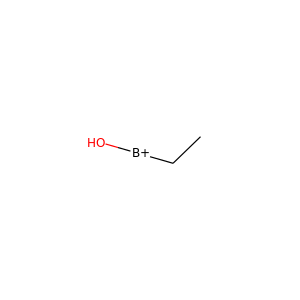

In [296]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)